In [1]:
from neo import Block
from neo.io import Spike2IO, NeoMatlabIO
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from kaveh.behavioral.oculomotor.trial import trial
from kaveh.sorting import spikesorter
from kaveh.toolbox import find_file
from kaveh.plots import axvlines
import numpy as np
from matplotlib import pyplot as plt
from smr import File
import csv
import os
import gc

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
# These are Buckley files with the following event structure:
# Event 0
# Event 1
# Event 2
# Event 3 : Trial onset
# Event 4 : Primary target presentation in adaptation trials
# Event 5 : Corrective target presentation in adaptation trials
# Event 6 : Divide each trial into its target jumps
# Event 7 : 
buckley_files_correct_events = ['B082107_1340_List.smr', #yes
'B090407_1526_List.smr', # yes
'B091208_1545_List.smr', # No done
'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'B101707_1333_List.smr', # yes
'B121407_1_1124_List.smr', # No done >> tuning doesn't match
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120108_1622_List.smr', # Yes --> actually no, the labled cs are nonsense; also weird saccades; needs more filtering
'W120208_1_1418_List.smr', # No done
'W120308_2_1714_List.smr', # Yes
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No

f_index = 6
f_name = find_file(buckley_files_correct_events[f_index], '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
f_name_csv = find_file(buckley_files_correct_events[f_index]+'.pkl.csv', '../data/david_neurons')
print(f_name)
print(f_name_csv)
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B082107/B082107_1340_List.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_25deg/B110807/B110807_1632_List.smr'

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091908_2/B091908_2_1550_List.smr
../data/david_neurons/B091908_2/B091908_2_1550_List.smr.pkl.csv


In [4]:
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]
events = seg.events

In [5]:
# Load cs times from smr files

cs_times = seg.spiketrains[0].times
# cs_times = np.union1d(seg.spiketrains[1].times, seg.spiketrains[0].times)*pq.s
cs_times.shape

(23206,)

In [6]:
# Load events
labels = np.unique(events[-1].labels)

event_times = [0]*labels.size

for i, label in enumerate(labels):
    event_times[i] = events[-1].times[events[-1].labels == label]
    
# Event 0
# Event 1
# Event 2
# Event 3 : Trial onset
# Event 4 : Primary target presentation in adaptation trials
# Event 5 : Corrective target presentation in adaptation trials
# Event 6 : Divide each trial into its target jumps
# Event 7 : 

In [7]:
for et in event_times:
    print(et.shape)

(803,)
(643,)
(1,)
(21,)
(321,)
(321,)
(162,)
(52,)
(1,)


In [8]:
# Load eye data
HE = seg.analogsignals[0].as_array()
t_HE = seg.analogsignals[0].times;

VE = seg.analogsignals[1].as_array()
t_VE = seg.analogsignals[1].times

HT = seg.analogsignals[2].as_array()
t_HT = seg.analogsignals[2].times

VT = seg.analogsignals[3].as_array()
t_VT = seg.analogsignals[3].times

eye_fs = seg.analogsignals[0].sampling_rate



In [9]:
# Load voltage
signal = seg.analogsignals[-1].as_array()
t_signal = seg.analogsignals[-1].times
signal_fs = seg.analogsignals[-1].sampling_rate

In [10]:
# Load cs times from csGUI csv files

with open(f_name_csv, 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader), dtype=np.int64)

cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
cs_times = t_signal[cs_indices]
cs_times.shape

(365,)

In [11]:
# create a list of trials based on wether events indicating primary target presentations 
# in adaptation trials exist or not (this is the way most of 2010_Adapt files are structured)
from kaveh.behavioral.oculomotor.trial import trial

trial_num = 0
start_time = event_times[3][trial_num]
end_time = event_times[3][trial_num + 1]
trials = []

while np.any(np.where((event_times[4] < end_time) & (event_times[4] > start_time))):
    print(trial_num)
    primary_target_times = event_times[4][np.where((event_times[4] < end_time) & (event_times[4] > start_time))]
    corrective_target_times = event_times[5][np.where((event_times[5] < end_time) & (event_times[5] > start_time))]
    trial_signal = signal[(t_signal > start_time) & (t_signal <= end_time)]
    trial_t_signal = t_signal[(t_signal > start_time) & (t_signal <= end_time)]
    trial_cs_times = cs_times[(cs_times > start_time) & (cs_times <= end_time)]
    
    trial_HT = HT[(t_HT > start_time) & (t_HT <= end_time)]
    trial_t_HT = t_HT[(t_HT > start_time) & (t_HT <= end_time)]
    
    trial_VT = VT[(t_VT > start_time) & (t_VT <= end_time)]
    trial_t_VT = t_VT[(t_VT > start_time) & (t_VT <= end_time)]
    
    trial_HE = HE[(t_HE > start_time) & (t_HE <= end_time)]
    trial_t_HE = t_HE[(t_HE > start_time) & (t_HE <= end_time)]
    
    trial_VE = VE[(t_VE > start_time) & (t_VE <= end_time)]
    trial_t_VE = t_VE[(t_VE > start_time) & (t_VE <= end_time)]
    
    trials = trials + [trial(trial_num, start_time, end_time, primary_target_times,
                             corrective_target_times, cs_times=trial_cs_times,
                             HT=trial_HT, t_HT= trial_t_HT, VT=trial_VT, t_VT=trial_t_VT,
                             HE=trial_HE, t_HE= trial_t_HE, VE=trial_VE, t_VE=trial_t_VE,
                             signal=trial_signal, t_signal=trial_t_signal)]
    trial_num = trial_num + 1
    if trial_num < len(event_times[3]) - 1:
        start_time = event_times[3][trial_num]
        end_time = event_times[3][trial_num + 1]
    else:
        break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [12]:
print(trials[0].trial_number)
print(trials[0].start_time)
print(trials[0].end_time)
print(trials[0].primary_target_times)
print(trials[0].corrective_target_times)
print(trials[0].t_signal[0], trials[0].t_signal[-1])
print(trials[0].signal.shape)
print(trials[0].cs_times)

0
0.019569999999999997 s
29.769809999999996 s
[ 0.92275  2.02884  7.93006  9.0382  11.44056 12.52768 16.85605 17.91811
 20.32048 21.37861 22.88098 23.96412 25.46647 26.54259 28.04495 29.17005] s
[ 1.12584  2.12298  8.1352   9.2063  11.6247  12.67678 17.01514 18.10025
 20.47561 21.5807  23.06112 24.17721 25.6396  26.71373 28.26705 29.32119] s
(array(0.01958) * s, array(29.7698) * s)
(1487512, 1)
[ 0.65854  1.23346  1.56972  2.4196   3.35304  3.5962   3.98582  4.2276
  4.79216  5.28462  5.47098  7.35996  8.38856  8.76796  8.96078  9.42808
  9.97904 11.347   12.03036 12.19602 13.2981  14.4826  15.4979  15.81968
 16.14604 18.26268 19.45342 19.80718 21.83646 23.20588 23.61098 26.6107
 27.17798 27.54102 27.9454  28.5338 ] s


In [13]:
import quantities as pq
cs_range = pq.quantity.Quantity(0.250, 's')

fired_complex_spikes_corrective = np.zeros((len(trials[0:-2]), 16))
fired_complex_spikes_primary = np.zeros((len(trials[0:-2]), 16))


trial_num = 0
for i, trial in enumerate(trials[0:-2]):
# trial = trials[trial_num]
#     print(trial.primary_target_dir)
#     print(trial.corrective_target_dir)
    for j, ctt in enumerate(trial.corrective_target_times):
        fired_complex_spikes_corrective[i][j] = np.count_nonzero(np.where(np.logical_and(trial.cs_times < ctt+cs_range, trial.cs_times > ctt )))
    for j, ptt in enumerate(trial.primary_target_times):
        next_corrective = trial.corrective_target_times[j] + pq.quantity.Quantity(0.050, 's')
        if j != np.where(trial.corrective_target_times >= ptt)[0][0] :
            raise ValueError('primary - corrective index mismatch: ptti = {}'.format(j))

        fired_complex_spikes_primary[i][j] = np.count_nonzero(np.where(np.logical_and(trial.cs_times < ptt +
                                                                                      min(cs_range, next_corrective),
                                                                                      trial.cs_times > ptt )))
    

if trials[0].primary_target_dir.size != trials[0].corrective_target_dir.size: 
    raise ValueError('Different number of directions in primary and corrective target presentations')
directions_primary = np.unique(trials[0].primary_target_dir)
dir_idx_primary = {}
for d in directions_primary:
    dir_idx_primary[d] = np.where(trials[0].primary_target_dir == d)[0]
    
directions_corrective = np.unique(trials[0].corrective_target_dir)
dir_idx_corrective = {}
for d in directions_corrective:
    dir_idx_corrective[d] = np.where(trials[0].corrective_target_dir == d)[0]



In [21]:
trials[0].primary_target_dir

array([  0., 180., 270.,  90., 315., 135.,  45., 225., 180.,   0., 225.,
        45., 135., 315.,  90., 270.])

In [14]:
cs_rate_primary = {}
cs_rate_corrective = {}
for d in dir_idx_primary:
    cs_rate_primary[d] = np.sum(fired_complex_spikes_primary[:, dir_idx_primary[d]])
for d in dir_idx_corrective:
    cs_rate_corrective[d] = np.sum(fired_complex_spikes_corrective[:, dir_idx_corrective[d]])
    

In [15]:
cs_rate_corrective

{0.0: 7.0,
 45.0: 5.0,
 90.0: 6.0,
 135.0: 2.0,
 180.0: 5.0,
 225.0: 3.0,
 270.0: 5.0,
 315.0: 3.0}

In [16]:
import operator
cs_on = max(cs_rate_corrective.items(), key=operator.itemgetter(1))[0]
cs_rate_corrective_cs_on_aligned = {}
for key, value in cs_rate_corrective.items():
    cs_rate_corrective_cs_on_aligned[key - cs_on] = value

# cs_on = max(cs_rate_corrective.items(), key=operator.itemgetter(1))[0]
cs_rate_primary_cs_on_aligned = {}
for key, value in cs_rate_primary.items():
    cs_rate_primary_cs_on_aligned[key - cs_on] = value

In [17]:
cs_rate_corrective_cs_on_aligned

{0.0: 7.0,
 45.0: 5.0,
 90.0: 6.0,
 135.0: 2.0,
 180.0: 5.0,
 225.0: 3.0,
 270.0: 5.0,
 315.0: 3.0}

In [18]:
cs_rate_primary_cs_on_aligned

{0.0: 5.0,
 45.0: 3.0,
 90.0: 2.0,
 135.0: 7.0,
 180.0: 6.0,
 225.0: 6.0,
 270.0: 4.0,
 315.0: 4.0}

<IPython.core.display.Javascript object>


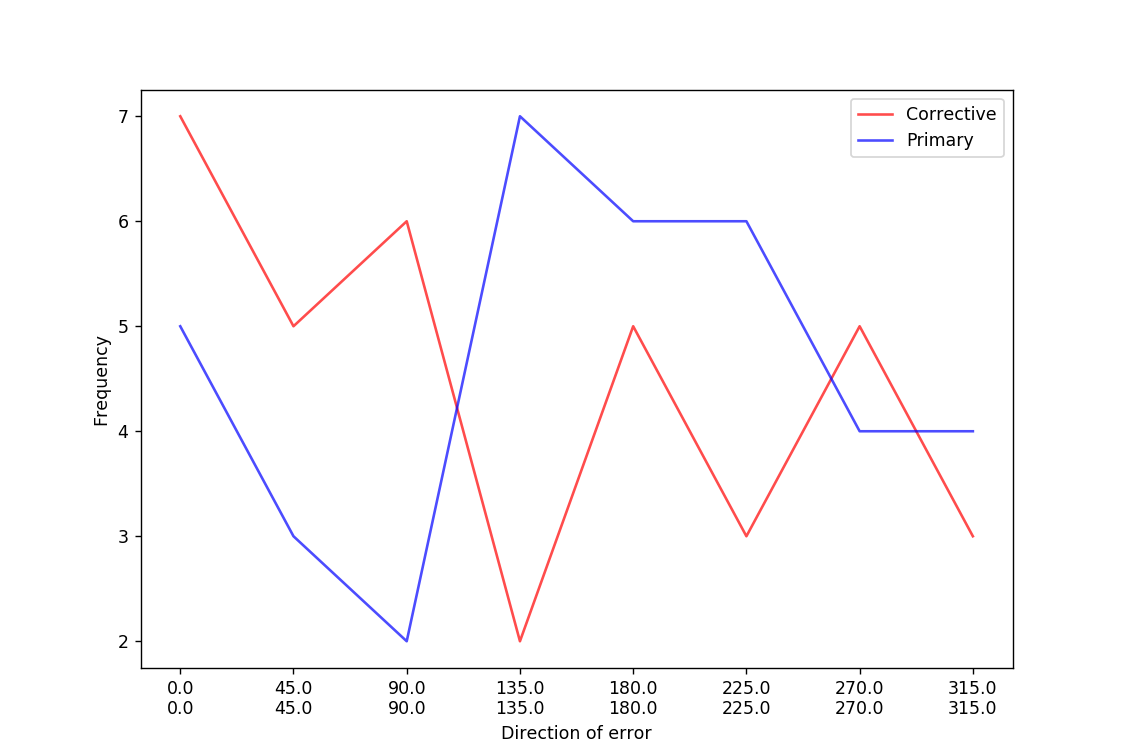

Text(0,0.5,u'Frequency')

In [19]:
[x_cor,y_cor] = zip(*sorted(cs_rate_corrective_cs_on_aligned.items()))
plt.figure(figsize=(9,6))
plt.plot(x_cor,y_cor, alpha=0.7, color='r')
[x_prim,y_prim] = zip(*sorted(cs_rate_primary_cs_on_aligned.items()))
plt.plot(x_prim,y_prim,  alpha=0.7,color='b')
x_ticks = [str(x_p)+'\n'+str(x_c) for x_p, x_c in zip(x_prim, x_cor)]
plt.xticks(x_prim, x_ticks)

plt.legend(['Corrective', 'Primary'])
plt.xlabel('Direction of error')
plt.ylabel('Frequency')

In [427]:
data = [0]*4
data[0] = x_cor
data[1] = y_cor
data[2] = x_prim
data[3] = y_prim


In [435]:
# Save tuning to csv
with open(f_name + '.tuning.csv', 'w') as the_file:
    csv.register_dialect("custom", delimiter=",", skipinitialspace=True)
    writer = csv.writer(the_file, dialect="custom")
    for tup in data:
        writer.writerow(tup)

In [ ]:
[str(x_p)+'\n'+str(x_c) for x_p, x_c in zip(x_prim, x_cor)]

<IPython.core.display.Javascript object>


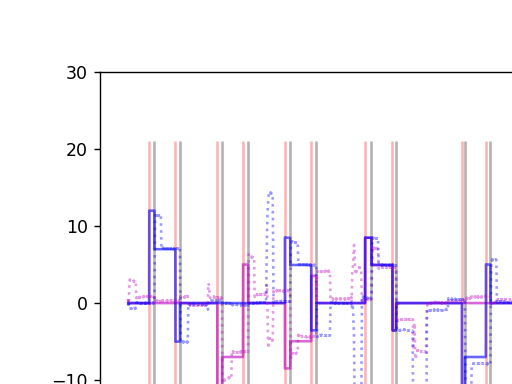

In [483]:

trial_num = 0
gc.collect()
plt.figure()
curr_trial = trials[trial_num]
plt.plot(curr_trial.t_VT, curr_trial.VT, alpha = 0.6, color = 'm')
plt.plot(curr_trial.t_HT, curr_trial.HT, alpha = 0.6, color = 'b')
plt.plot(curr_trial.t_VE, curr_trial.VE, alpha = 0.4, color = 'm', linestyle = ':')
plt.plot(curr_trial.t_HE, curr_trial.HE, alpha = 0.4, color = 'b', linestyle = ':')
plt.legend(['VT', 'HT', 'VE', 'HE'])
plt.ylim((-30, 30))
plt.eventplot(curr_trial.primary_target_times, linelengths=40, colors='r', alpha = 0.3)
plt.eventplot(curr_trial.corrective_target_times, linelengths=40, colors='k', alpha = 0.3)
plt.eventplot
plt.show()

In [484]:
plt.savefig('../data/plots/one-block.png')

In [256]:

ptt = curr_trial.primary_target_times[5]

In [ ]:
np.where(curr_trial.corrective_target_times >= ptt)[0][0]

In [ ]:
# # divide trials
# trial_num = 5

# start_time = event_times[3][trial_num]
# end_time = event_times[3][trial_num + 1]

# gc.collect()
# plt.figure()
# plt.plot(t_VT[(t_VT > start_time) & (t_VT <= end_time)], VT[(t_VT > start_time) & (t_VT <= end_time)], alpha = 0.5, color = 'm')
# plt.plot(t_HT[(t_HT > start_time) & (t_HT <= end_time)], HT[(t_HT > start_time) & (t_HT <= end_time)], alpha = 0.5, color = 'b')
# plt.plot(t_VE[(t_VE > start_time) & (t_VE <= end_time)], VE[(t_VE > start_time) & (t_VE <= end_time)], alpha = 0.5, color = 'g')
# plt.plot(t_HE[(t_HE > start_time) & (t_HE <= end_time)], HE[(t_HE > start_time) & (t_HE <= end_time)], alpha = 0.5, color = 'y')
# plt.legend(['VT', 'HT', 'VE', 'HE'])
# plt.ylim((-30, 30))
# plt.eventplot(event_times[4][(event_times[4] > start_time) & (event_times[4] <= end_time)], linelengths=40, colors='r', alpha = 0.3)
# # plt.eventplot(corr_sac_times_adpt[(corr_sac_times_adpt > start_time) & (corr_sac_times_adpt <= end_time)], linelengths=40, colors='lime', alpha = 0.3)
# plt.show()

In [ ]:
plt.plot(curr_trial.t_HE, curr_trial.HE, alpha = 0.5, color = 'y')


<IPython.core.display.Javascript object>


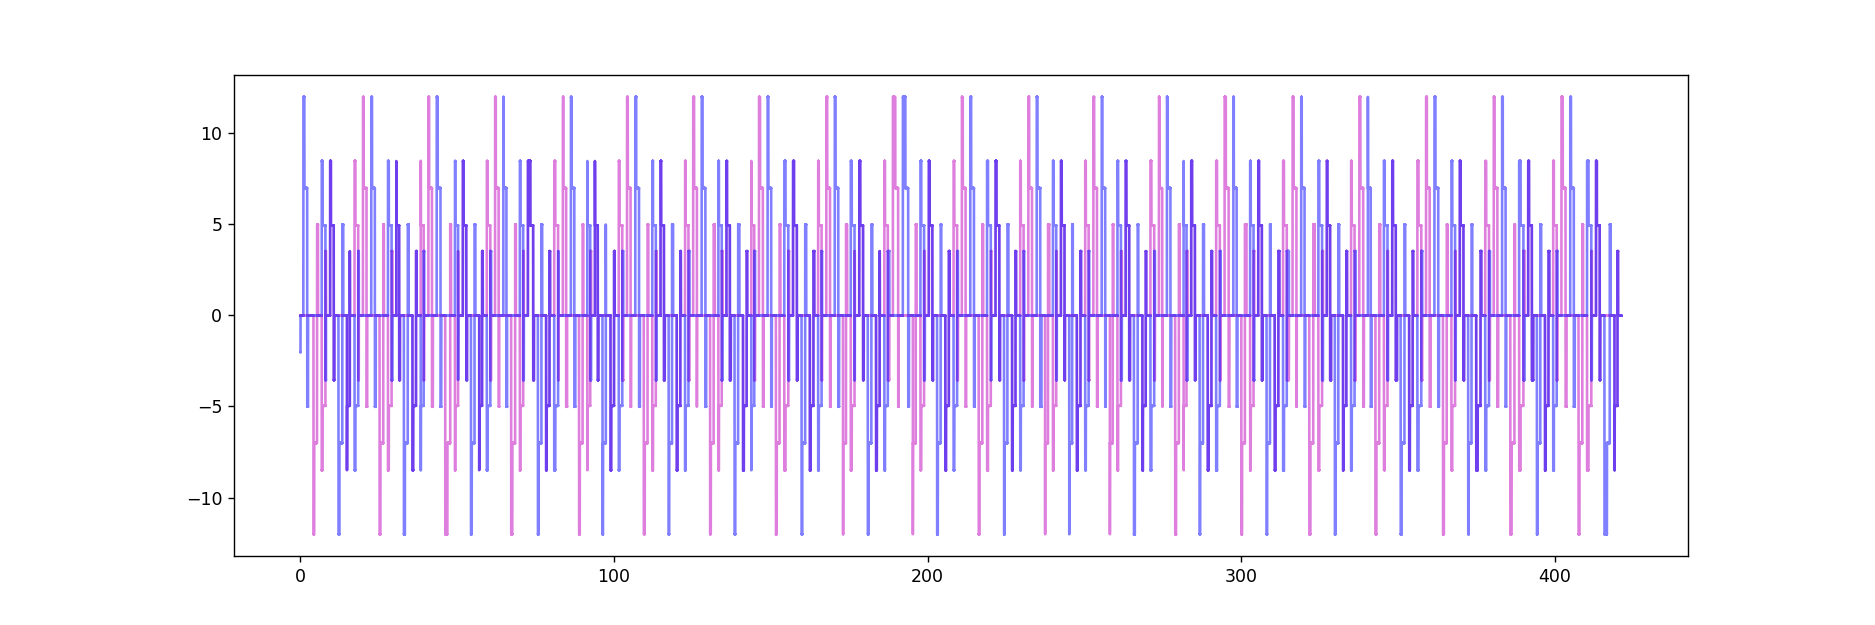

In [361]:
plt.figure(figsize=(15,5))
plt.plot(t_VT, VT, alpha = 0.5, color = 'm')
plt.plot(t_HT, HT, alpha = 0.5, color = 'b')

# plt.plot(t_VE, VE, alpha = 0.5, color = 'g')
# plt.plot(t_HE, HE, alpha = 0.5, color = 'r')
# plt.eventplot(event_times[3], linelengths=30, colors='k')
plt.show()